# Data Science Capstone  
## Analyzing Gaming Addiction Trends and Player Engagement


In [263]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
import itertools

import warnings
warnings.filterwarnings('ignore')

The `games_data` and `users_data` datasets were extracted from the **Steam Web API**, specifically using the **ISteamApps/GetAppList** and **IPlayerService/GetOwnedGames** endpoints.  

- **`steam_game_data.csv`** : This dataset contains detailed information about 23,132 games, including metadata such as the game title, developer, publisher, genre, release date, supported platforms, multiplayer support, graphics quality, story depth, and metrics like review scores and player engagement statistics.  

- **`user_playtime_data.csv`** : This dataset consists of 18,479 player-specific data, capturing metrics like total playtime, recent playtime, and game ownership information. Each user (`user_id`) can have multiple games (`game_id`) associated with their account.  

Let's load these datasets:  

##  `games_data`

In [264]:
games_data = pd.read_csv("steam_game_data.csv")
users_data = pd.read_csv("user_playtime_data.csv")

In [265]:
# Let's look at the first 5 elements of the games_data
games_data.head()

,game_id,title,developer,publisher,genre,release_date,platforms,multiplayer_support,graphics_quality,story_depth,DLC_count,max_concurrent_players,positive_review_pct,average_review_score,review_sentiment_score,number_of_reviews
0,10,Counter-Strike,Valve,Valve,Action,"Nov 1, 2000","windows, mac, linux",True,Standard,Light,0,158072,88,88,88,158072
1,20,Team Fortress Classic,Valve,Valve,Action,"Apr 1, 1999","windows, mac, linux",True,Standard,Light,0,6458,0,0,0,6458
2,30,Day of Defeat,Valve,Valve,Action,"May 1, 2003","windows, mac, linux",True,Standard,Light,0,4220,79,79,79,4220
3,40,Deathmatch Classic,Valve,Valve,Action,"Jun 1, 2001","windows, mac, linux",True,Standard,Light,0,2285,0,0,0,2285
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,Action,"Nov 1, 1999","windows, mac, linux",True,Standard,Light,0,21555,0,0,0,21555


In [266]:
games_data.count()

game_id                   23132
title                     23130
developer                 23131
publisher                 23115
genre                     18512
release_date              23109
platforms                 23132
multiplayer_support       23132
graphics_quality          23132
story_depth               23132
DLC_count                 23132
max_concurrent_players    23132
positive_review_pct       23132
average_review_score      23132
review_sentiment_score    23132
number_of_reviews         23132
dtype: int64

We can observe that most columns in the `games_data` dataset have 23,132 entries, with a few exceptions like `title`, `developer`, `publisher`, `genre`, and `release_date`, suggesting potential missing values.


In [267]:
games_data.shape

(23132, 16)

In [268]:
games_data.dtypes

game_id                    int64
title                     object
developer                 object
publisher                 object
genre                     object
release_date              object
platforms                 object
multiplayer_support         bool
graphics_quality          object
story_depth               object
DLC_count                  int64
max_concurrent_players     int64
positive_review_pct        int64
average_review_score       int64
review_sentiment_score     int64
number_of_reviews          int64
dtype: object

Most of the data in the `games_data` dataset are of the `object` type, with numerical metrics stored as `int64` and `multiplayer_support` as a boolean (`bool`).


In [269]:
#let's look for the missing values

games_missing_values = games_data.isnull().sum()
games_missing_values

game_id                      0
title                        2
developer                    1
publisher                   17
genre                     4620
release_date                23
platforms                    0
multiplayer_support          0
graphics_quality             0
story_depth                  0
DLC_count                    0
max_concurrent_players       0
positive_review_pct          0
average_review_score         0
review_sentiment_score       0
number_of_reviews            0
dtype: int64

### Let's remove those missing values:

In [270]:
# Removing rows with any missing values
games_data.dropna(inplace=True)

In [271]:
games_data.shape

(18479, 16)

After removing missing values, the `games_data` dataset is reduced to **18,479 rows** across **16 columns**,

In [272]:
games_data.count()

game_id                   18479
title                     18479
developer                 18479
publisher                 18479
genre                     18479
release_date              18479
platforms                 18479
multiplayer_support       18479
graphics_quality          18479
story_depth               18479
DLC_count                 18479
max_concurrent_players    18479
positive_review_pct       18479
average_review_score      18479
review_sentiment_score    18479
number_of_reviews         18479
dtype: int64

In [273]:

# Attemptting to parse the dates with possible date formats : 
# Possible formats known from: https://steamcommunity.com/sharedfiles/filedetails/?id=2554483179#:~:text=Date%20part%20order%20can%20be,format%20will%20be%20applied%20immediately.

valid_dates_format1 = pd.to_datetime(games_data['release_date'], format='%d %b, %Y', errors='coerce')
valid_dates_format2 = pd.to_datetime(games_data['release_date'], format='%b %d, %Y', errors='coerce')
valid_dates_format3 = pd.to_datetime(games_data['release_date'], format='%d %b %Y', errors='coerce')

# Identify rows that do not match either of the formats
invalid_dates = games_data[(valid_dates_format1.isna()) & (valid_dates_format2.isna()) & (valid_dates_format3.isna())]

# Display rows with invalid date formats
print("Rows with invalid date formats:")
print(invalid_dates[['release_date']])

print("There are a total of ", len(invalid_dates), "invalid dates")


Rows with invalid date formats:
          release_date
343    19 дек. 2014 г.
568    30 листоп. 2018
988    To be announced
989            Q4 2025
992            Q2 2025
...                ...
23109             2025
23112      Coming soon
23119          Q2 2025
23123  To be announced
23125      Coming soon

[5665 rows x 1 columns]
There are a total of  5665 invalid dates


We can observe that for some games that have not been released yet, the `release_date` column contains values like **Q2 2025**, **To be announced**, and **Coming soon**, along with some dates in different language formats, so let's remove them since we won't be needing those for our analysis.


In [274]:
# let's remove those invalid dates
invalid_dates_list = invalid_dates['release_date'].tolist()
games_data = games_data[~games_data['release_date'].isin(invalid_dates_list)]

In [275]:
games_data.count()

game_id                   12814
title                     12814
developer                 12814
publisher                 12814
genre                     12814
release_date              12814
platforms                 12814
multiplayer_support       12814
graphics_quality          12814
story_depth               12814
DLC_count                 12814
max_concurrent_players    12814
positive_review_pct       12814
average_review_score      12814
review_sentiment_score    12814
number_of_reviews         12814
dtype: int64

After removing those invalid dates, the `games_data` dataset now contains **12,814** entries across all columns. We now have only relevant release dates are included for analysis.

Now, let's make the date format consistent in all rows


In [276]:
# Combining all parsed dates
games_data['release_date'] = valid_dates_format1.fillna(valid_dates_format2).fillna(valid_dates_format3)

# Convert dates to 'YYYY-MM-DD' format for consistency only
games_data['release_date'] = games_data['release_date'].dt.strftime('%Y-%m-%d')

# `users_data`

In [277]:
# Let's look at the first 5 elements of the users_data
users_data.head()

,user_id,game_count,appid,name,playtime_forever,playtime_2weeks
0,76561198807776733,8,578080,PUBG: BATTLEGROUNDS,27303,0
1,76561198807776733,8,730,Counter-Strike 2,21,0
2,76561198807776733,8,1418630,Dread Hunger,38737,2
3,76561198807776733,8,2349820,Hero's Land,889,0
4,76561198807776733,8,1203220,NARAKA: BLADEPOINT,0,0


In [278]:
users_data.count()

user_id             65494
game_count          65494
appid               65494
name                65494
playtime_forever    65494
playtime_2weeks     65494
dtype: int64

The `users_data` dataset contains **65,494** entries across all columns.

In [279]:
users_data.shape

(65494, 6)

In [280]:
users_data.dtypes

user_id              int64
game_count           int64
appid                int64
name                object
playtime_forever     int64
playtime_2weeks      int64
dtype: object

Most of the data in the `users_data` dataset are of the `int64` type, with only the `name` column being of the `object` type. We have numerical data for user gaming behavior analysis.


In [281]:
# let's look for missing values
users_missing_values = users_data.isnull().sum()
users_missing_values

user_id             0
game_count          0
appid               0
name                0
playtime_forever    0
playtime_2weeks     0
dtype: int64

No mising values

In [282]:
# Rename the column from 'appid' to 'game_id'
users_data.rename(columns={'appid': 'game_id'}, inplace=True)

Since one user can have multiple data entries, the `user_id` column can be repeated for the same person, so let's check the number of unique users and unique games in the `users_data` dataset.


In [283]:
print("There are ", len(users_data['user_id'].unique()) , " unique users in our user dataset")

There are  1097  unique users in our user dataset


In [284]:
print("There are ", len(users_data['game_id'].unique()) , " unique games in our user dataset")

There are  10629  unique games in our user dataset


In [285]:
# if they played RECENTLY, playtime_2weeks will be greater than 0

# Filter players with recent playtime (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played recently: {unique_recent_players_count}")


Number of unique users who played recently: 340


In [286]:
# If they are genuine players, `playtime_forever` will be greater than 0.
# I am considering the fact that some users might just create an account and never actually play.


# Filter players with at least some playtime (playtime_forever > 0)
recent_players = users_data[users_data['playtime_forever'] > 0]

# Get the count of unique users
unique_recent_players_count = recent_players['user_id'].nunique()

print(f"Number of unique users who played at least a min: {unique_recent_players_count}")


Number of unique users who played at least a min: 974


In [287]:
# let's add avg_playtime coloumn - for viz
users_data['avg_playtime'] = users_data['playtime_2weeks'] / 14

Let's do some visualizations

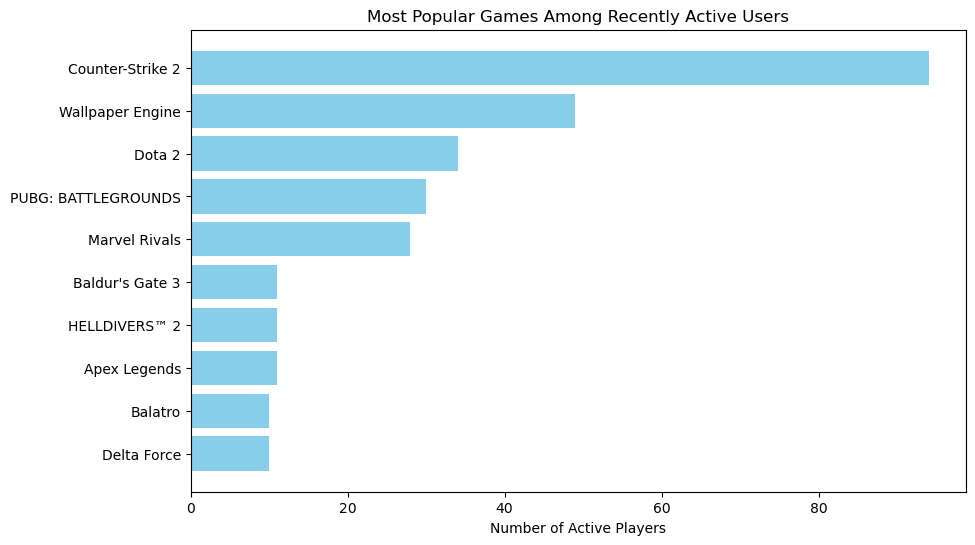

In [288]:

# Most Popular Games Among Recently Active Users (playtime_2weeks > 0)
recent_players = users_data[users_data['playtime_2weeks'] > 0]
most_popular_games = recent_players['name'].value_counts().head(10).reset_index()
most_popular_games.columns = ['Game', 'Active Players']

# Visualization: Most Popular Games
plt.figure(figsize=(10, 6))
plt.barh(most_popular_games['Game'], most_popular_games['Active Players'], color='skyblue')
plt.xlabel('Number of Active Players')
plt.title('Most Popular Games Among Recently Active Users')
plt.gca().invert_yaxis()
plt.show()


The bar chart shows **Counter-Strike 2** leading by a significant margin, followed by **Wallpaper Engine** and **Dota 2**.

Interestingly, while **Counter-Strike 2**, **Dota 2**, and **PUBG: BATTLEGROUNDS** are well-known for maintaining high player counts globally, titles like **Marvel Rivals** and **Wallpaper Engine** attract players with their casual and practical uses.


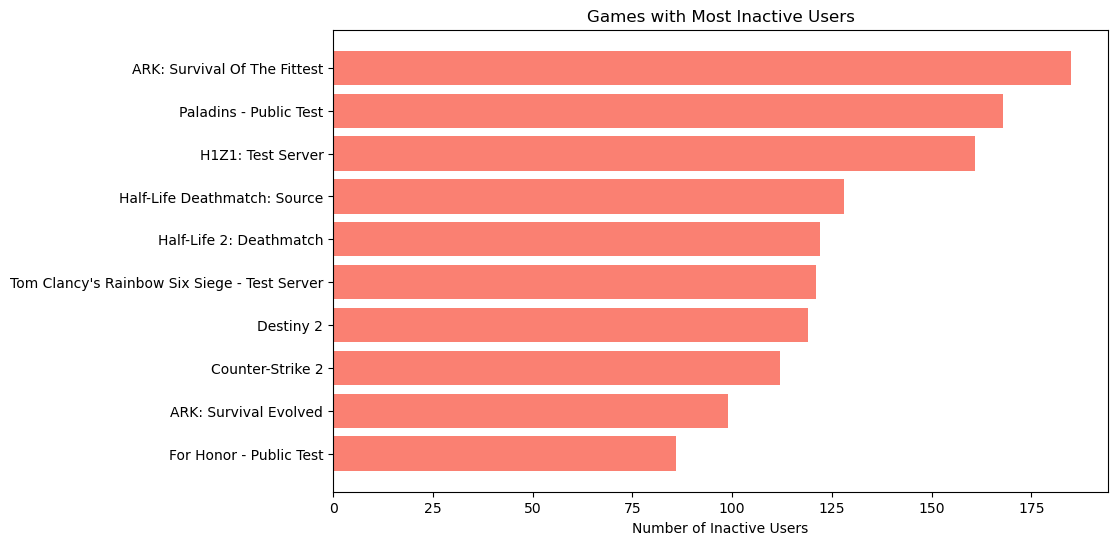

In [289]:
# Inactive Users with Zero Playtime and Their Associated Games
inactive_users = users_data[(users_data['playtime_forever'] == 0) & (users_data['playtime_2weeks'] == 0)]
inactive_user_games = inactive_users['name'].value_counts().head(10).reset_index()
inactive_user_games.columns = ['Game', 'Inactive User Count']

plt.figure(figsize=(10, 6))
plt.barh(inactive_user_games['Game'], inactive_user_games['Inactive User Count'], color='salmon')
plt.xlabel('Number of Inactive Users')
plt.title('Games with Most Inactive Users')
plt.gca().invert_yaxis()
plt.show()


The bar chart shows **ARK: Survival Of The Fittest**, **Paladins - Public Test**, and **H1Z1: Test Server** leading the list.  

Interestingly, many of the top inactive games are **test servers** or **public test versions**, suggesting that players might try these versions briefly without continuing to play regularly.  

Let's also note here that even popular titles like **Counter-Strike 2** and **Destiny 2** appear on this list. This indicates that not all players remain engaged over time.


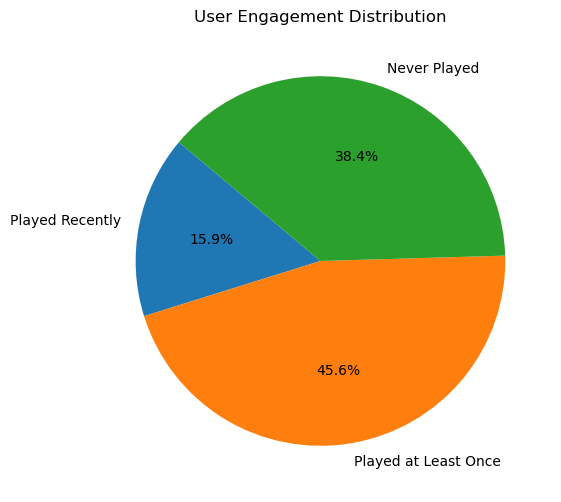

In [290]:
# lets see how many played recently, played at least once and never played at all
engagement_labels = ['Played Recently', 'Played at Least Once', 'Never Played']
engagement_counts = [
    recent_players['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] > 0]['user_id'].nunique(), 
    users_data[users_data['playtime_forever'] == 0]['user_id'].nunique()
]

plt.figure(figsize=(6, 6))
plt.pie(engagement_counts, labels=engagement_labels, autopct='%1.1f%%', startangle=140)
plt.title('User Engagement Distribution')
plt.show()

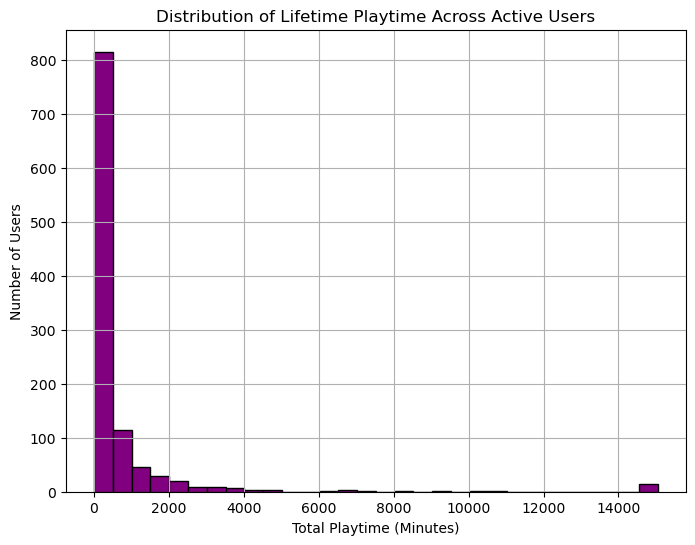

In [291]:
# let's observe the distribution of lifetime Playtime Across Active Users

# Filter only users with playtime_forever > 0
active_users = users_data[users_data['playtime_2weeks'] > 0]

# Create a histogram for active users
plt.figure(figsize=(8, 6))
plt.hist(active_users['playtime_2weeks'], bins=30, color='purple', edgecolor='black')
plt.xlabel('Total Playtime (Minutes)')
plt.ylabel('Number of Users')
plt.title('Distribution of Lifetime Playtime Across Active Users')
plt.grid(True)
plt.show()


According to the histogram, the majority of users have a **low total playtime**, mainly under **2000 minutes**.  

The **right-skewed distribution** indicates that while most players spend limited time in games, a small number of users have **extremely high playtimes**, potentially pointing to **high engagement** or **gaming addiction**.

We will later explore these **outliers** to understand what drives such high playtime and if specific games contribute to this behavior.


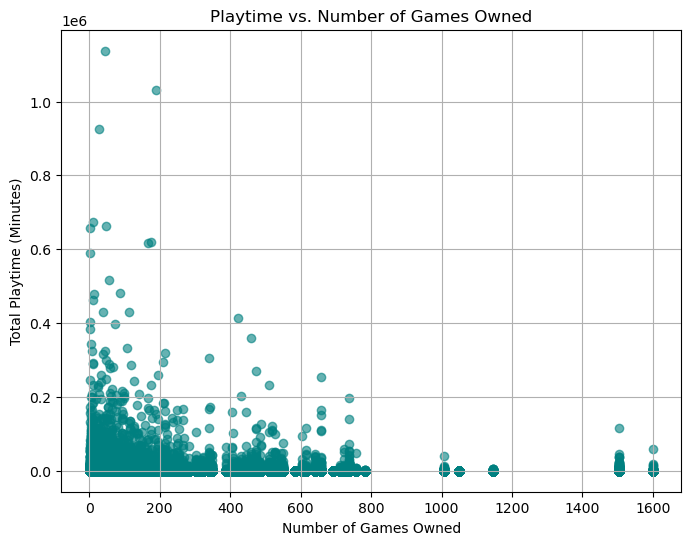

In [292]:
plt.figure(figsize=(8, 6))
plt.scatter(users_data['game_count'], users_data['playtime_forever'], alpha=0.6, color='teal')
plt.xlabel('Number of Games Owned')
plt.ylabel('Total Playtime (Minutes)')
plt.title('Playtime vs. Number of Games Owned')
plt.grid(True)
plt.show()


The scatter plot shows most users clustering around **low playtime** and **fewer owned games**.  

While a few users own **hundreds to over a thousand games**, their total playtime does not always scale up, suggesting that **game collectors**(those who own lots of games) may not necessarily be **active players**.  

Again, we can see few **outliers** with **extremely high playtime**, indicating possible **addictive behavior**, regardless of the total number of games owned.


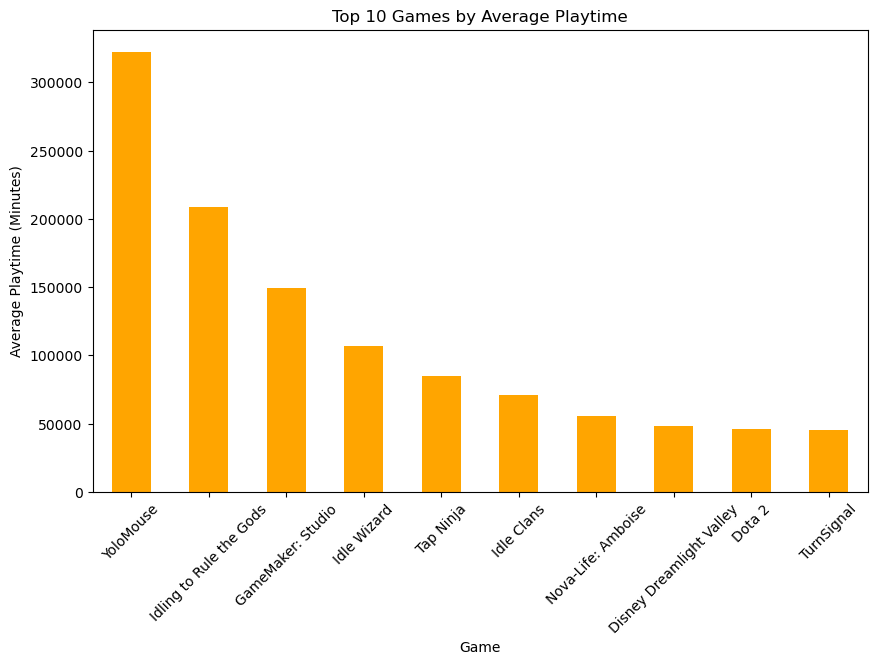

In [293]:
average_playtime_per_game = users_data.groupby('name')['playtime_forever'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
average_playtime_per_game.plot(kind='bar', color='orange')
plt.xlabel('Game')
plt.ylabel('Average Playtime (Minutes)')
plt.title('Top 10 Games by Average Playtime')
plt.xticks(rotation=45)
plt.show()


The bar chart shows **YoloMouse** leading by a significant margin, followed by **Idling to Rule the Gods** and **GameMaker: Studio**.  

Most of these top games with high average playtime are **idle games**, which often encourage **longer running sessions** without active engagement.  

But we can see **Dota 2**, which interestingly is the only **competitive multiplayer game** in this list, showing that while **idle games** dominate average playtime, some traditional games also maintain **high engagement** among their player base.


In [294]:
#Dherai game khelne haru
high_playtime_count = (users_data['playtime_2weeks'] / 2 > 1800).sum()
high_playtime_count

37

## Q1. How much time are people spending on gaming per week, and what does it reveal about gaming addiction trends?

In [295]:
# let's first filter only active users
active_users = users_data[users_data['playtime_2weeks'] > 0]

# calculate weekly playtime (in hours) for those active uses
active_users['weekly_playtime_hours'] = (active_users['playtime_2weeks'] / 2) / 60

# Descriptive statistics of weekly playtime 
active_playtime_stats = active_users['weekly_playtime_hours'].describe()
print("Weekly Playtime Statistics for Active Users (in Hours):")
print(active_playtime_stats)


Weekly Playtime Statistics for Active Users (in Hours):
count    1078.000000
mean        5.596746
std        16.274544
min         0.008333
25%         0.200000
50%         0.920833
75%         4.104167
max       125.391667
Name: weekly_playtime_hours, dtype: float64


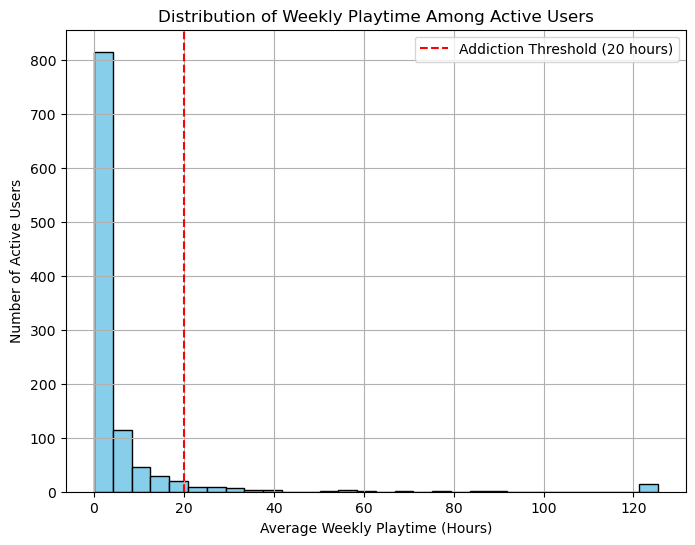

In [296]:
# visualization the  distribution of weekly playtime
plt.figure(figsize=(8, 6))
plt.hist(active_users['weekly_playtime_hours'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=20, color='red', linestyle='--', label='Addiction Threshold (20 hours)')
plt.xlabel('Average Weekly Playtime (Hours)')
plt.ylabel('Number of Active Users')
plt.title('Distribution of Weekly Playtime Among Active Users')
plt.legend()
plt.grid(True)
plt.show()


Active User Distribution by Playtime Category:
playtime_category
Casual Gamer           902
Moderate Gamer         118
Potential Addiction     59
Name: count, dtype: int64


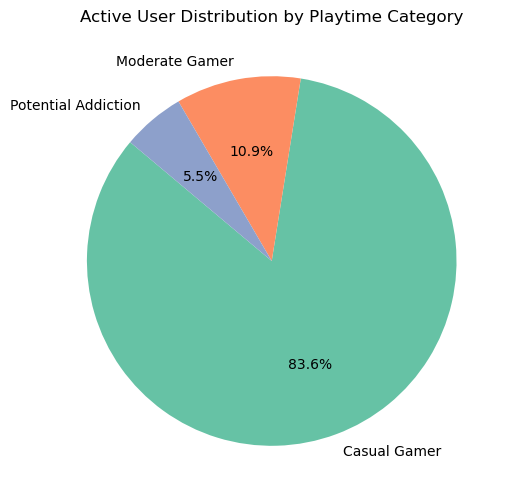

In [298]:

# Lets also cateogrize active users based on weekly playtime
def categorize_playtime(hours):
    if hours < 7:
        return 'Casual Gamer'
    elif hours < 20:
        return 'Moderate Gamer'
    else:
        return 'Potential Addiction'

active_users['playtime_category'] = active_users['weekly_playtime_hours'].apply(categorize_playtime)

# total active users in each category
active_category_counts = active_users['playtime_category'].value_counts()
print("\nActive User Distribution by Playtime Category:")
print(active_category_counts)

plt.figure(figsize=(6, 6))
plt.pie(active_category_counts, labels=active_category_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Active User Distribution by Playtime Category')
plt.show()



- **Majority of Active Users:** 83.6% are **Casual Gamers**, playing **less than 7 hours per week**.  
- **Moderate Gamers:** 10.9% play **between 7 to 20 hours per week**, showing **healthy engagement**.  
- **Potential Addiction:** 5.5% of active users exceed **20 hours per week**, indicating a **possible risk of gaming addiction**.  


With only **5.5%** of active users in the '**Potential Addiction**' category, **gaming addiction** does not seem to be a **significant trend** in the dataset.  

The overwhelming majority of active users are **casual gamers**. This suggests that **most people use gaming as a light, recreational activity**. And also may indicate that **games are engaging enough for short sessions but not overly addictive**.  


The **10.9%** **moderate gamers** represent an **opportunity to boost engagement**, potentially through **in-game events**, **rewards**, or **social features** to convert moderate users into **highly engaged (but healthy) gamers**.  


The **histogram** shows a **long tail**, with a **few users playing well beyond 40 hours per week**.


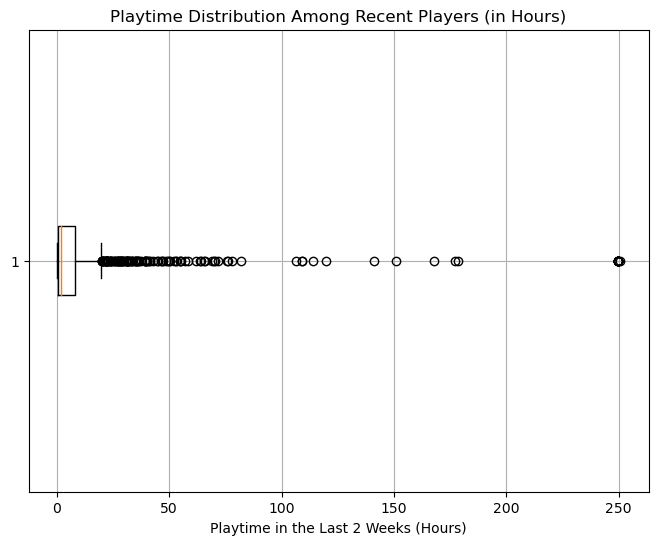

In [299]:
# let's see a box plot
recent_players['playtime_hours'] = recent_players['playtime_2weeks'] / 60

plt.figure(figsize=(8, 6))
plt.boxplot(recent_players['playtime_hours'], vert=False)
plt.xlabel('Playtime in the Last 2 Weeks (Hours)')
plt.title('Playtime Distribution Among Recent Players (in Hours)')
plt.grid(True)
plt.show()